
# NLP: Predicciendo la polaridad de reseñas usando Deep Learning

La importancia de la satisfacción del cliente radica en que nos ayuda a saber la probabilidad de que un cliente haga una compra a futuro. Pedir a los clientes que califiquen el grado de satisfacción es una buena forma de ver si se convertirán en clientes habituales o incluso en defensores de la marca.

En el presente proyecto crearemos un modelo de Machine Learning que predica el número de estrellas que recibiría un producto con base en el comentario que haya dejado un cliente. Para ello utilizaremos el dataset de reseñas de Amazon en español. 

<div class="alert alert-warning">
<b>The Multilingual Amazon Reviews Corpus</b> <br>
Se puede acceder al dataset <a href="https://drive.google.com/uc?export=download&id=11XnXB7Ubgf3t6gotXGlM4FCwPOMHhDLX">aquí</a>. Es un comprimido .zip que contiene tres archivos .json. Más información sobre el dataset <a href="https://registry.opendata.aws/amazon-reviews-ml/">aquí</a>. Es importante que tengas en cuenta la <a href="https://docs.opendata.aws/amazon-reviews-ml/license.txt">licencia</a> de este dataset.
</div>

## 1. Preprocesado
### 1.1 Importaciones y configuración 

Importamos las librerías necesarias

In [21]:
''' Data manipulation '''
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack

''' Visualization '''
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

''' NLP '''
import re
import nltk

''' Machine Learning '''
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

'''Deep Learning '''
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model

''' Misc '''
import sys, os, re, csv, codecs, gc
from time import time

Configuramos el estilo de los gráficos

In [2]:
from matplotlib.colors import LinearSegmentedColormap

# Palette
blue = '#146EF5'
red = '#ED3767'
amber = '#F5B14C'
mint = '#17BED1'
purple = '#815ADB'
pink = '#FE90AD'

# Cualitative colormap
palette = [blue, red, pink, purple, amber, mint]

# Sequential colormap
bluemint = LinearSegmentedColormap.from_list("myBlues", [mint, blue])
redpink = LinearSegmentedColormap.from_list("myReds", [pink, red])
redwhite = LinearSegmentedColormap.from_list("myReds", ['white', red])
bluewhite = LinearSegmentedColormap.from_list("myReds", ['white', blue])

# Diverging colormap
bluered = LinearSegmentedColormap.from_list("myBlueRed", [red, "white", blue])
blupurred = LinearSegmentedColormap.from_list("myBlueRed", [red, purple, blue])
rainbow = LinearSegmentedColormap.from_list("myBlueRed", [pink, red, purple, blue, mint])

params = {'axes.edgecolor': '0.9', 'axes.labelcolor': '0.4',
          'text.color': '0.3', 'xtick.color': '0.5', 'ytick.color': '0.5',
          'font.size': 16, 'axes.titlesize': 16, 'axes.labelsize': 12,
          'xtick.labelsize': 12, 'ytick.labelsize': 12,
          'figure.figsize': (9, 6), 'axes.spines.right': False, 'axes.spines.top': False}

sns.set(context='notebook', style='white', palette=palette, rc=params)

### 1.2 Carga de datos y preprocesamiento

Cargamos los datos

In [3]:
train = pd.read_csv('/work/processed_data/train.csv')
dev = pd.read_csv('/work/processed_data/dev.csv')
test = pd.read_csv('/work/processed_data/test.csv')

In [4]:
X_train = train[['full_text', 'clean_text']].copy()
X_dev = dev[['full_text', 'clean_text']].copy()
X_test = test[['full_text', 'clean_text']].copy()

In [5]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=100, dtype=np.float32)

train_ngrams =  vectorizer.fit_transform(X_train['clean_text'])
dev_ngrams = vectorizer.transform(X_dev['clean_text'])
test_ngrams = vectorizer.transform(X_test['clean_text'])

# Obtenemos los nombres de las features
features_ngrams = np.array(vectorizer.get_feature_names())

Ahora extraemos las features indirectas:
mean_word_len,
count_stopwords,
word_unique_percent,
count_word, count_letters,
count_unique_word.

In [6]:
nltk.download('stopwords')
stopword_list = nltk.corpus.stopwords.words('spanish')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
train_indirect = pd.DataFrame()
train_indirect['count_word'] = X_train['full_text'].apply(lambda x: len(str(x).split()))
train_indirect['count_letters'] = X_train['full_text'].apply(lambda x: len(str(x)))
train_indirect['count_unique_word'] = X_train['full_text'].apply(lambda x: len(set(str(x).split())))
train_indirect["count_stopwords"] = X_train["full_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in stopword_list]))
train_indirect["mean_word_len"] = X_train["full_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
train_indirect['word_unique_percent'] = train_indirect['count_unique_word']*100/train_indirect['count_word']

In [8]:
dev_indirect = pd.DataFrame()
dev_indirect['count_word'] = X_dev['full_text'].apply(lambda x: len(str(x).split()))
dev_indirect['count_letters'] = X_dev['full_text'].apply(lambda x: len(str(x)))
dev_indirect['count_unique_word'] = X_dev['full_text'].apply(lambda x: len(set(str(x).split())))
dev_indirect["count_stopwords"] = X_dev["full_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in stopword_list]))
dev_indirect["mean_word_len"] = X_dev["full_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
dev_indirect['word_unique_percent'] = dev_indirect['count_unique_word']*100/dev_indirect['count_word']

In [9]:
test_indirect = pd.DataFrame()
test_indirect['count_word'] = X_test['full_text'].apply(lambda x: len(str(x).split()))
test_indirect['count_letters'] = X_test['full_text'].apply(lambda x: len(str(x)))
test_indirect['count_unique_word'] = X_test['full_text'].apply(lambda x: len(set(str(x).split())))
test_indirect["count_stopwords"] = X_test["full_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in stopword_list]))
test_indirect["mean_word_len"] = X_test["full_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_indirect['word_unique_percent'] = test_indirect['count_unique_word']*100/test_indirect['count_word']

Leemos los datasets de polaridad

In [10]:
train_polarity = pd.read_csv('/work/processed_data/train_polarity.csv')
dev_polarity = pd.read_csv('/work/processed_data/dev_polarity.csv')
test_polarity = pd.read_csv('/work/processed_data/test_polarity.csv')

Solo falta juntar todas las features en un matriz dispersa

In [11]:
X_train = hstack((train_ngrams, train_indirect,  train_polarity)).tocsr()
X_dev = hstack((dev_ngrams, dev_indirect,  dev_polarity)).tocsr()
X_test = hstack((test_ngrams, test_indirect,  test_polarity)).tocsr()

## 2. Modelado 
El proyecto pasado explicamos que el problema requiere ser abordado como una tarea de clasificación binaria puesto que los datos no permiten obtener una gran exactitud al predecir 5 clases.
Por ello, ahora trataremos de mejorar el accuracy obtenido con Linear SVC (0.86 en el set de validación) con un arquitectura de redes neuronales.

### 2.1 Linear SVC (benchmark)
Predecimos manteniendo solo 2 clases: negativo y postivo (convirtiendo las reviews con 3 estrellas en _negativo_)

In [23]:
def binarize(x):
    if x == 4 or x == 5:
        return 1
    else:
        return 0
    
y_train = train['stars'].apply(binarize)
y_dev = dev['stars'].apply(binarize)
y_test = test['stars'].apply(binarize)

In [24]:
svc = LinearSVC(penalty='l2', dual=False, tol=1e-4, C=0.01)

svc.fit(X_train, y_train)

y_train_pred_svc = svc.predict(X_train)
y_dev_pred_svc = svc.predict(X_dev)
y_test_pred_svc = svc.predict(X_test)

print('Accuracy en el set de Train:', accuracy_score(y_train, y_train_pred_svc))
print('Accuracy en el set de Dev:', accuracy_score(y_dev, y_dev_pred_svc))
print('Accuracy en el set de Test:', accuracy_score(y_test, y_test_pred_svc), '<---')

Accuracy en el set de Train: 0.869985
Accuracy en el set de Dev: 0.869
Accuracy en el set de Test: 0.8646 <---


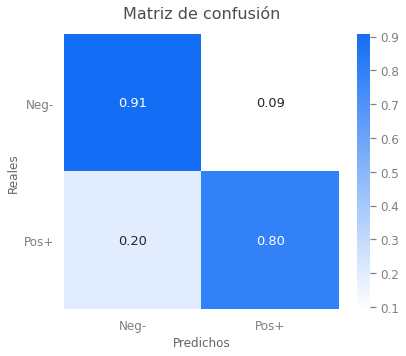

In [25]:
plt.figure(figsize=(6, 5))
conf_sent = confusion_matrix(y_test, y_test_pred_svc, 
                             labels=[0, 1], 
                             normalize='true')
sns.heatmap(data = conf_sent, cbar=True, square=True, annot=True, 
            fmt= '.2f', annot_kws={'size': 13}, 
            xticklabels= ['Neg-', 'Pos+'], 
            yticklabels=['Neg-', 'Pos+'], 
            cmap=bluewhite)

plt.title('Matriz de confusión', pad=16)
plt.ylabel('Reales')
plt.xlabel('Predichos')
plt.xticks(rotation = 0)
plt.yticks(rotation = 0)
plt.tight_layout()
plt.show()

#### 2.1.2 Neural Network

El enfoque que utilizaremos será crear una red neuronal usando la arquitecura LSTM, la que alimentaremos usando el texto limpio que ya
prepocesamos en el notebook del proyecto anterior.

In [30]:
# Extraemos la lista de los comentarios para cada set
list_sentences_train = train['clean_text']
list_sentences_dev = dev['clean_text']
list_sentences_test = test['clean_text']

Para transformar el corpus en números que la red pueda entender haremos esto: lo que vamos a hacer:

1. **Tokenización:** Necesitamos descomponer la frase en palabras únicas.
2. **Indexación:** Ponemos las palabras en una estructura similar a un diccionario y les damos un índice a cada una.
3. **Representación del índice:** Representamos la secuencia de palabras en los comentarios en forma de índice, y alimentar esta cadena de índices en nuestro LSTM.

In [ ]:
# Definimos el número máximo de features
